# Insurance Data

The goal of this notebook is to retrieve, clean, and preproces insurance data, based on the following data sources.
- ZIP Code-level breakdowns of new, renewed, and non-renewal data for 2015-2021 (https://www.insurance.ca.gov/01-consumers/200-wrr/DataAnalysisOnWildfiresAndInsurance.cfm)
- Residential Property Coverage Amounts, Wildfire Risk, and Losses for 2018-2023 (https://www.insurance.ca.gov/01-consumers/200-wrr/WildfireRiskInfoRpt.cfm)
- FAIR Plan insured units for 2022 (https://www.insurance.ca.gov/01-consumers/200-wrr/DataAnalysisOnWildfiresAndInsurance.cfm)

Additionally, the notebook also used the dataset "CA Zip Code Boundaries" (https://gis.data.ca.gov/datasets/ca-zip-code-boundaries/) for mapping and EDA.

In [112]:
# # Install GeoPandas package to deal with geospatial data and map
# !conda install geopandas
# # or
# !conda install -c conda-forge geopandas

In [113]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [114]:
# base folders

RAW_DATA_DIR = Path('../raw_data/')
DATA_DIR = Path('../data/')

In [115]:
# years to slice the data
start_year = 2018
end_year = 2021

## Zipcodes

Loading and prepocessing geospatial data on zipcodes (zipcode, population, and pop density) for EDA.

In [116]:
zipcodes = gpd.read_file(RAW_DATA_DIR / 'USA_ZIP_Code_Areas.geojson')
zipcodes.shape

(1778, 8)

In [117]:
zipcodes.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,geometry
0,12,00012,Mt Meadows Area,CA,0.0,0.00,30.92,"POLYGON ((-13474731.772 4903282.532, -13474716..."
1,16,00016,Sequoia National Forest,CA,26.0,0.66,39.33,"POLYGON ((-13189602.036 4239987.11, -13189590...."
2,17,00017,Northeast Fresno County,CA,0.0,0.00,564.41,"POLYGON ((-13267161.108 4503250.18, -13267159...."
3,18,00018,Los Padres Ntl Forest,CA,0.0,0.00,90.83,"POLYGON ((-13255913.164 4096587.096, -13255912..."
4,19,00019,Lassen Ntl Forest,CA,17.0,0.04,412.59,"POLYGON ((-13398996.781 4949420.395, -13398824..."


In [118]:
# removing zipcodes where the population == 0
zipcodes = zipcodes[zipcodes['POPULATION'] > 0]

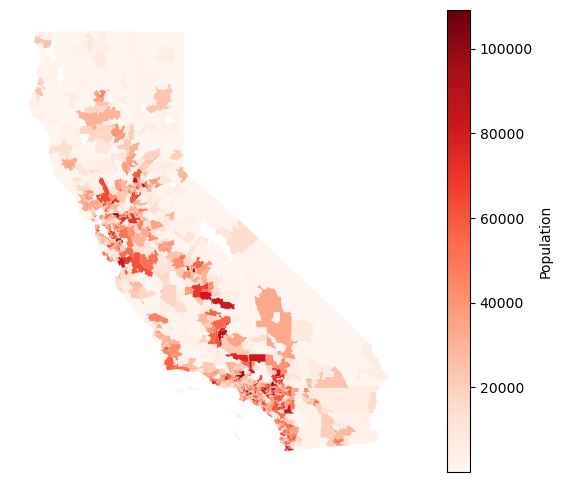

In [119]:
ax = zipcodes.plot(column='POPULATION',
                   cmap='Reds',
                   figsize=(10, 6),
                   legend=True,
                   legend_kwds={'label': 'Population'},
                   ax=None)

ax.set_axis_off();

In [120]:
zipcodes.rename(columns={'ZIP_CODE': 'ZIP Code'}, inplace=True)

In [121]:
zipcodes.to_file(DATA_DIR / 'CA_zipcodes.geojson')

## Renewals (2015-2021)

CA releases annual counts of renewals of residential policies. We use the dataset for 2015-2021 as it indicates wheter non-rewenals were initiated for by insurance companies or homeowners. (The data for 2020-2023 doesn't make this distinction.) The code below cleans the data and add new features that will be explored in EDA and potentially incorporated into our final model.

In [200]:
renewals = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Voluntary-Market-New-Renew-NonRenew-by-ZIP-2015-2021.xlsx',
                          dtype={'ZIP Code': str})
renewals.head(2)

,County,ZIP Code,Year,New,Renewed,Insured-Initiated Nonrenewed,Insurer-Initiated Nonrenewed
0,Los Angeles,90001,2015,734,5092,415,178
1,Los Angeles,90002,2015,807,5006,472,198


In [201]:
renewals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15538 entries, 0 to 15537
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   County                        14821 non-null  object
 1   ZIP Code                      15538 non-null  object
 2   Year                          15538 non-null  int64 
 3   New                           15538 non-null  int64 
 4   Renewed                       15538 non-null  int64 
 5   Insured-Initiated Nonrenewed  15538 non-null  int64 
 6   Insurer-Initiated Nonrenewed  15538 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 849.9+ KB


In [202]:
# removing zipcodes that aren't associated with a county
renewals = renewals[renewals['County'].isnull() == False]

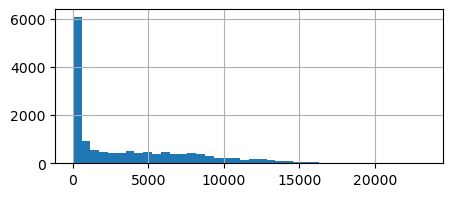

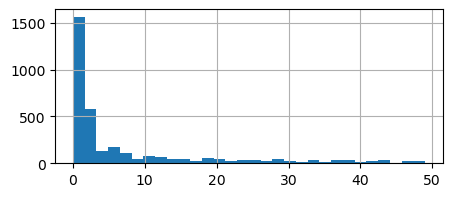

In [203]:
# removing zipcodes with very few renewals 

# The assumption here is that these zipcodes with few policies are associated with non-residential entities, 
# such as hospitals, college campuses, etc. Therefore, they are not covered by "regular" policies (i.e., a 
# homeowner contracts a insurance policy from a company).

renewals['Renewed'].hist(bins=40, figsize=(5,2))
plt.show()

renewals[renewals['Renewed'] < 50].Renewed.hist(bins=30, figsize=(5,2))
plt.show()

In [234]:
# removing  Zipcodes while less the N renewals
n = 10
cond1 = renewals['Renewed'] >= n

# filtering columns of interest and 
cond2 = renewals['Year'] >= start_year
cond3 = renewals['Year'] <= end_year

mask = cond1 & cond2 & cond3

In [280]:
# filtering years and columns and renaming

cols = ["ZIP Code", "New", "Renewed", "Insured-Initiated Nonrenewed", "Insurer-Initiated Nonrenewed"]

renewals_filtered = renewals.loc[mask, cols].copy()
renewals_filtered = renewals_filtered.groupby('ZIP Code', as_index=False).sum()

renaming = {
    'New' : 'new_policies',
    'Renewed': 'renewed_policies',
    'Insured-Initiated Nonrenewed': 'company_nonrenewed',
    'Insurer-Initiated Nonrenewed': 'owner_nonrenewed',
}
renewals_filtered.rename(columns=renaming, inplace=True)

renewals_filtered.sample(3)

,ZIP Code,new_policies,renewed_policies,company_nonrenewed,owner_nonrenewed
1197,95123,6342,54627,5526,632
484,92359,1296,8049,876,310
527,92543,6372,27896,4367,1512


### Added features

Since the dataset has the raw counts of policies (non-)renewals, we can add new features with their proportions.

In [282]:
# number of non-renewed policies and  expiring policies (or contracts up to renewal) 
renewals_filtered['nonrenewed_policies'] = renewals_filtered['company_nonrenewed'] + renewals_filtered['owner_nonrenewed']
renewals_filtered['expiring_policies'] = renewals_filtered['nonrenewed_policies'] + renewals_filtered['renewed_policies']

# percentage of non-renewed policies of the expiring policies
renewals_filtered['pct_nonrenewed_policies'] = renewals_filtered['nonrenewed_policies'] / renewals_filtered['expiring_policies']

# percentage of policies not-renewals by the initiative of the owner or company
renewals_filtered['pct_nonrenewed_owner'] = renewals_filtered['owner_nonrenewed'] / renewals_filtered['expiring_policies']
renewals_filtered['pct_nonrenewed_company'] = renewals_filtered['company_nonrenewed'] / renewals_filtered['expiring_policies']

# ratio of new policies to non-renewed policies
renewals_filtered['ratio_new_to_nonrenewed'] = renewals_filtered['new_policies'] / (renewals_filtered['owner_nonrenewed'] + renewals_filtered['company_nonrenewed'])

renewals_filtered.sample(3)

,ZIP Code,new_policies,renewed_policies,company_nonrenewed,owner_nonrenewed,nonrenewed_policies,expiring_policies,pct_nonrenewed_policies,pct_nonrenewed_owner,pct_nonrenewed_company,ratio_new_to_nonrenewed
291,91801,2674,29107,2200,477,2677,31784,0.084225,0.015008,0.069217,0.998879
642,93010,5172,43680,4172,789,4961,48641,0.101992,0.016221,0.085771,1.042532
794,93518,202,1570,165,78,243,1813,0.134032,0.043023,0.091009,0.831276


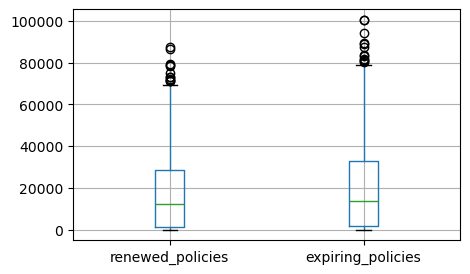

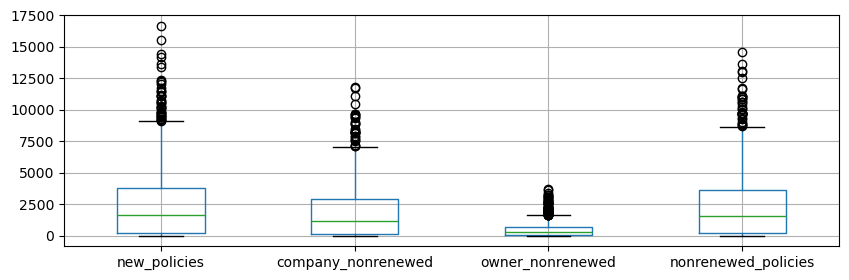

In [285]:
# checking for extreme outliers
raw_numbers1 = ['renewed_policies', 'expiring_policies']
raw_numbers2 = ['new_policies', 'company_nonrenewed', 'owner_nonrenewed', 'nonrenewed_policies']

renewals_filtered[raw_numbers1].boxplot(figsize=(5,3))
plt.show()
renewals_filtered[raw_numbers2].boxplot(figsize=(10,3))
plt.show()

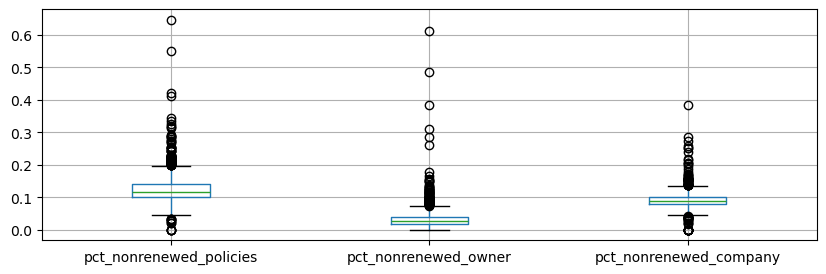

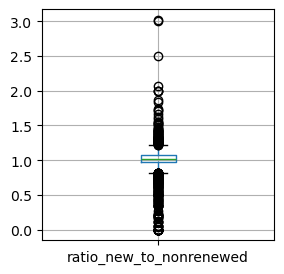

In [284]:
pcts = ['pct_nonrenewed_policies', 'pct_nonrenewed_owner', 'pct_nonrenewed_company']

renewals_filtered[pcts].boxplot(figsize=(10,3))
plt.show()

renewals_filtered[['ratio_new_to_nonrenewed']].boxplot(figsize=(3,3))
plt.show()

In [267]:
#renewals.to_csv(DATA_DIR / 'renewals_yearly.csv')
renewals_filtered.to_csv(DATA_DIR / '2018_2021' / 'policy_renewals.csv')

In [289]:
readme = """
Dataset: policy_renewals.csv
Coverage: 2018-2021


'ZIP Code'
'new_policies': number of new policies underwritten
'renewed_policies': number of policies renewed
'company_nonrenewed': number of policies not renewed by insurance company initiative
'owner_nonrenewed': number of policies not renewed by homeowner initiative
'pct_nonrenewed_policies': percentage of non-renewed policies from expiring policies 
'pct_nonrenewed_owner': percentage of non-renewed policies initiated by homeowners
'pct_nonrenewed_company': percentage of non-renewed policies initiated by insurance companies
'ratio_new_to_nonrenewed': ratio between non-renewed policies and new policies
"""

with open(DATA_DIR / '2018_2021' / 'policy_renewals_readme.txt', 'w') as file:
    file.write(readme)

## FAIR Plan (2022)

The California FAIR Plan provides basic fire insurance coverage for high-risk properties when traditional insurance companies will not. The California FAIR Plan It has recently expanded to offer higher coverage limits of $3 million for residential policyholders and $20 million for commercial policies per location, serving as a safety net for properties that can't obtain coverage in the standard insurance market.

At the zipcode level, we have data for 2022 about residential units with market insurance and FAIR insurance. (The data in available in PDF, but ChatGPT quickly converted to tabular format.)

*** NOTE: There is a better dataset here https://www.cfpnet.com/key-statistics-data/

In [5]:
fair = pd.read_excel(RAW_DATA_DIR / 'full_residential_units_insured_2022.xlsx')

In [6]:
fields = ['ZIP Code', "Voluntary Market Units", "FAIR Plan Units"]
fair = fair[fields]
fair.head()

,ZIP Code,Voluntary Market Units,FAIR Plan Units
0,90001,6913,2104
1,90002,6534,1330
2,90003,8716,1934
3,90004,4710,495
4,90005,996,100


In [7]:
# calculate percentages
fair['Total Ins Units'] = fair['Voluntary Market Units'] + fair['FAIR Plan Units']

fair['Pct Market'] = fair['Voluntary Market Units'] / fair['Total Ins Units']
fair['Pct FAIR'] = fair['FAIR Plan Units'] / fair['Total Ins Units']

fair.sample(3)

,ZIP Code,Voluntary Market Units,FAIR Plan Units,Total Ins Units,Pct Market,Pct FAIR
624,92881,7843,69,7912,0.991279,0.008721
355,92081,6451,14,6465,0.997834,0.002166
157,90810,6372,208,6580,0.968389,0.031611


In [9]:
# remove zipcodes with less the n units
n = 30
fair = fair[fair['Total Ins Units'] > n]

In [10]:
fair.to_csv(DATA_DIR / 'fair_plan2022.csv')

## FAIR Plan 2 (2020-2024)

This dataset contains FAIR Plan information for multiple years (2020-24) as well as information about the total exposure. However, it doesn't include data about the total market policies like the previous dataset.

Also, there are data for residential and commercial policies, but this notebook only deals with residential ones.

In [80]:
# Policies
columns_pol = ['ZIP Code', 
               'growth_pol_23_24', 'policies_24',
               'growth_pol_22_23', 'policies_23',
               'growth_pol_21_22', 'policies_22',
               'growth_pol_20_21', 'policies_21',
               'policies_20']
fair2_pol = pd.read_excel(RAW_DATA_DIR / 'CFP5yearPIFGrowthbyzipcodethrough09302024(Residential+line)20241112v001_unlocked.xlsx', names=columns_pol)

# Exposure
columns_exp = ['ZIP Code', 
               'growth_exp_23_24', 'exposure_24',
               'growth_exp_22_23', 'exposure_23',
               'growth_exp_21_22', 'exposure_22',
               'growth_exp_20_21', 'exposure_21',
               'exposure_20']
fair2_exp = pd.read_excel(RAW_DATA_DIR / 'CFP5yearTIVGrowthbyzipcodethrough09302024(Residentialline)20241112v001_unlocked.xlsx', names=columns_exp)

In [81]:
# removing rows that doesn't contain actual data (totals, etc.)
from pandas.api.types import is_integer, is_number

fair2_pol = fair2_pol[fair2_pol['ZIP Code'].apply(is_integer)].copy()
fair2_exp = fair2_exp[fair2_exp['ZIP Code'].apply(is_integer)].copy()

fair2_pol.shape, fair2_exp.shape

((1647, 10), (1647, 10))

In [82]:
fair2_exp.head(3)

,ZIP Code,growth_exp_23_24,exposure_24,growth_exp_22_23,exposure_23,growth_exp_21_22,exposure_22,growth_exp_20_21,exposure_21,exposure_20
2,94501,0.676,98431342,0.179,58719416,0.137,49797731,0.091,43791971,40143917
3,94502,13.274,6880050,0.025,481983,1.85,470279,0,165000,165000
4,94536,1.995,40642190,0.852,13571624,0.307,7327808,0.264,5605823,4435256


In [83]:
fair2_pol.head(3)

,ZIP Code,growth_pol_23_24,policies_24,growth_pol_22_23,policies_23,growth_pol_21_22,policies_22,growth_pol_20_21,policies_21,policies_20
2,94501,0.333,104,0.04,78,-0.063,75,0,80,80
3,94502,2.5,7,0,2,1,2,0,1,1
4,94536,2.105,59,0.727,19,0.222,11,-0.1,9,10


In [84]:
# merging datasets
fair2 = pd.merge(fair2_pol, fair2_exp, on='ZIP Code')
fair2.head()

,ZIP Code,growth_pol_23_24,policies_24,growth_pol_22_23,policies_23,growth_pol_21_22,policies_22,growth_pol_20_21,policies_21,policies_20,growth_exp_23_24,exposure_24,growth_exp_22_23,exposure_23,growth_exp_21_22,exposure_22,growth_exp_20_21,exposure_21,exposure_20
0,94501,0.333,104,0.04,78,-0.063,75,0,80,80,0.676,98431342,0.179,58719416,0.137,49797731,0.091,43791971,40143917
1,94502,2.5,7,0,2,1,2,0,1,1,13.274,6880050,0.025,481983,1.85,470279,0,165000,165000
2,94536,2.105,59,0.727,19,0.222,11,-0.1,9,10,1.995,40642190,0.852,13571624,0.307,7327808,0.264,5605823,4435256
3,94538,1.4,24,0.667,10,0.2,6,0.25,5,4,1.445,15574256,1.647,6370385,0.771,2406677,0.352,1358996,1004964
4,94539,2.471,59,1.125,17,1.667,8,-0.25,3,4,1.934,79814473,0.983,27207162,2.696,13722261,-0.094,3712311,4096084


In [85]:
fair2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ZIP Code          1649 non-null   object
 1   growth_pol_23_24  1649 non-null   object
 2   policies_24       1649 non-null   object
 3   growth_pol_22_23  1649 non-null   object
 4   policies_23       1649 non-null   object
 5   growth_pol_21_22  1649 non-null   object
 6   policies_22       1649 non-null   object
 7   growth_pol_20_21  1649 non-null   object
 8   policies_21       1649 non-null   object
 9   policies_20       1649 non-null   object
 10  growth_exp_23_24  1649 non-null   object
 11  exposure_24       1649 non-null   object
 12  growth_exp_22_23  1649 non-null   object
 13  exposure_23       1649 non-null   object
 14  growth_exp_21_22  1649 non-null   object
 15  exposure_22       1649 non-null   object
 16  growth_exp_20_21  1649 non-null   object
 17  exposure_21   

In [86]:
# convert all columns to float and set to 0 empty values
def clean_non_ints(val):
    return 0 if is_number(val) == False else val

fair2 = fair2.map(clean_non_ints)


In [87]:
fair2.to_csv(DATA_DIR / 'fair_plan.csv')

## Premiums (2018-2023)

California requires insurance companies to report data on their policies every other year for these types of policies: 1.0 (Dwelling Fire), 4.0 (Homeowners), or 12 (EQ only - earthquake?). This dataset provides aggregate data at the zip code level for the 2018-2023 period, including:
- total earned premiums
- total earned exposure (technically, the sum of all claims, but the data doesn't seem to match gradular data on losses)
- fire risk classification
- claims and loss data 

Loss data includes the total amounts of paid losses and number of claims. It's organized in the combination of three categories:
1. Catastrophic/non-catastrophic events
2. Type of Coverage: Coverage A covers only damage to dwelling-unit while Coverage C covers also loss of property.
3. Type of Claim: Smoke or Fire (the only categories included here)


In [28]:
premiums = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Coverage-Amounts-Wildfire-Risk-and-Losses.xlsx', sheet_name='Cleaned', header=3)
premiums.head()

,Year,Zipcode,Earned Premium,Earned Exposure,Average Cov A,Average Cov C,Average PPC Class,Average Fire Risk,Count Negligible,Count Low,...,Non-Cat Cov C Smoke Claims,Non-Cat Cov C Smoke Losses,Cat Cov A Fire Claims,Cat Cov A Fire Losses,Cat Cov A Smoke Claims,Cat Cov A Smoke Losses,Cat Cov C Fire Claims,Cat Cov C Fire Losses,Cat Cov C Smoke Claims,Cat Cov C Smoke Losses
0,2018,94501,901497,2009,71317.19,53721.01,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,2018,94502,783059,1633,75639.82,64906.95,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,2018,94536,1043609,2950,51794.92,32987.53,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,2018,94538,738548,2164,49993.05,31687.20,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,2018,94539,573613,1589,59052.51,33615.72,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [29]:
# keep only columns of interest
features = ['Year', 'Zipcode', 'Earned Premium']
premiums = premiums[features]

In [30]:
# removing "Grand total" and "County" rows from the dataset 
premiums = premiums[premiums.Zipcode.apply(type) == int]

# removing annual counts as well
premiums = premiums[premiums.Zipcode > 100]

In [31]:
premiums.rename(columns={'Zipcode': 'ZIP Code'}, inplace=True)

In [32]:
premiums.sample(10)

,Year,ZIP Code,Earned Premium
2501,2018,95864,10036
16980,2019,92405,766238
5936,2018,93529,563451
58865,2022,91501,429626
18762,2019,92880,15846896
57889,2022,95065,19347
14051,2019,94516,11956
713,2018,92840,462640
57061,2022,91390,285016
15212,2019,92122,7040


In [89]:
# Yearly rate of change

premiums_year = pd.pivot_table(premiums, 'Earned Premium', 'ZIP Code', 'Year')
premiums_year.dropna(subset=(2018, 2021), inplace=True)
premiums_year['Pct Change 2018-21'] = (premiums_year[2021] - premiums_year[2018]) / premiums_year[2018]


In [90]:
premiums_year.sample(3)

Year,2018,2019,2020,2021,2022,2023,Pct Change 2018-21
ZIP Code,,,,,,,
92627,1.255556e+06,1.354583e+06,1.550837e+06,1.674337e+06,1.829563e+06,2.014408e+06,0.333543
95117,5.533006e+05,5.863260e+05,6.495063e+05,6.870419e+05,7.338813e+05,7.780399e+05,0.241715
95386,2.160621e+05,2.305627e+05,2.649954e+05,3.330483e+05,3.758138e+05,4.041437e+05,0.541447


In [100]:
# removing outliers

cond1 = premiums_year['Pct Change 2018-21'] < 2
cond2 = premiums_year['Pct Change 2018-21'] > -1

premiums_year = premiums_year[cond1 & cond2]

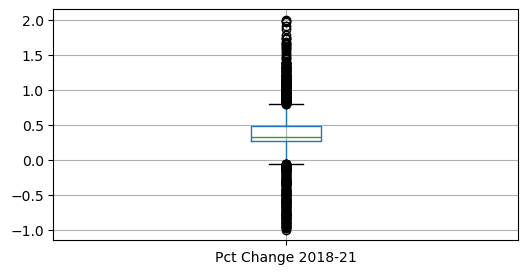

In [104]:
premiums_year[['Pct Change 2018-21']].boxplot(figsize=(6,3))
plt.show()

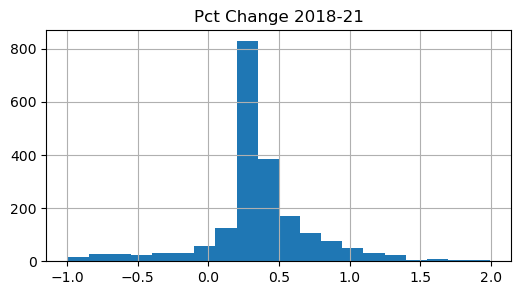

In [105]:
premiums_year[['Pct Change 2018-21']].hist(bins=20, figsize=(6,3))
plt.show()

In [106]:
premiums.to_csv(DATA_DIR / 'premiums_yearly.csv')
premiums_year.to_csv(DATA_DIR / 'premiums_totals.csv')

## FEMA Projected Premium Increases (2021, 2025)

FEMA created a methodology to predict monthly prices increases (Risk Rating 2.0) and publishes zipcode-level data based on it. The data consists of $10-increment columns with number of policies that they predict to change. They also have data for all the policies and for only single-housing units.

https://www.fema.gov/flood-insurance/risk-rating/profiles

In [103]:
fema = pd.read_excel(RAW_DATA_DIR / 'fema_risk-rating-zip-breakdown-california_2021.xlsx', header=3, sheet_name='SFH Zip Count')

# drop State column and Grand Total row
fema.drop(columns='State', inplace=True)
fema = fema[fema.columns[:-1]]

fema.tail()

,Zip Code,< -$100,$-100 to $-90,$-90 to $-80,$-80 to $-70,$-70 to $-60,$-60 to $-50,$-50 to $-40,$-40 to $-30,$-30 to $-20,...,$10 to $20,$20 to $30,$30 to $40,$40 to $50,$50 to $60,$60 to $70,$70 to $80,$80 to $90,$90 to $100,> $100
1456,96161,6.0,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,CA Total of ZIPs w/ <5 Policies,43.0,4.0,4.0,5.0,4.0,7.0,4.0,5.0,5.0,...,29.0,7.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1458,CA Unknown ZIP,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,00052 <5 Policies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,NaN,7464.0,814.0,934.0,1277.0,1519.0,1835.0,1977.0,2094.0,2372.0,...,10326.0,3132.0,611.0,109.0,46.0,16.0,1.0,7.0,3.0,8.0


In [104]:
# removing totals and zipcodes with less than 5 policies and other non-zipcode-level data
fema = fema[fema['Zip Code'].str.len() == 5]

# replace NaN for 0 and force int (instead of float)
fema[fema.columns[1:]] = fema[fema.columns[1:]].replace(np.nan, 0).apply(pd.to_numeric).astype(int)

fema

,Zip Code,< -$100,$-100 to $-90,$-90 to $-80,$-80 to $-70,$-70 to $-60,$-60 to $-50,$-50 to $-40,$-40 to $-30,$-30 to $-20,...,$10 to $20,$20 to $30,$30 to $40,$40 to $50,$50 to $60,$60 to $70,$70 to $80,$80 to $90,$90 to $100,> $100
2,90004,1,0,0,0,2,0,0,0,1,...,2,0,0,0,0,0,0,0,0,0
3,90005,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,90006,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
5,90007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,90008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,96145,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1453,96146,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1454,96148,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1455,96150,10,2,0,1,1,0,1,1,1,...,8,7,0,0,0,0,0,0,0,0


The original data is binned in very small buckets ($10 changes), which makes the information very hard to digest. I'll simplify to only 6 buckets and multiply for 12 months, to get the annual change.

In [105]:
# creating the bins
bin50_100_minus = fema.columns[2:7]
bin0_50_minus = fema.columns[7:12]
bin0_50 = fema.columns[12:17]
bin50_100 = fema.columns[17:22]


new_df = {'ZIP Code': fema['Zip Code'],
          '< -$100': fema['< -$100'],
          '-$100 to -$50': np.sum(fema[bin50_100_minus], axis=1),
          '-$50 to -$0': np.sum(fema[bin0_50_minus], axis=1),
          '$0 to $50': np.sum(fema[bin0_50], axis=1),
          '$50 to $100': np.sum(fema[bin50_100], axis=1),
          '> $100': fema['> $100']
}

projs = pd.DataFrame(new_df)
projs.sample(5)

,ZIP Code,< -$100,-$100 to -$50,-$50 to -$0,$0 to $50,$50 to $100,> $100
1310,95825,6,6,371,434,0,0
612,93221,3,2,5,20,0,0
110,90621,0,0,0,29,0,0
1115,95370,2,0,1,31,0,0
1377,96001,11,9,17,195,0,0


In [106]:
projs['n_decrease'] = np.sum(projs[projs.columns[1:4]], axis=1)
projs['n_increase'] = np.sum(projs[projs.columns[4:7]], axis=1)
projs['ratio_inc_to_dec'] = projs['n_decrease'] / projs['n_increase']
projs.sample(3)

,ZIP Code,< -$100,-$100 to -$50,-$50 to -$0,$0 to $50,$50 to $100,> $100,n_decrease,n_increase,ratio_inc_to_dec
1204,95565,1,0,2,3,0,0,3,3,1.000000
752,93657,13,23,24,111,0,0,60,111,0.540541
97,90405,0,0,0,55,0,0,0,55,0.000000


In [107]:
projs.to_csv(DATA_DIR / 'premium_change2021.csv')